In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import PandasTools

PandasTools.RenderImagesInAllDataFrames(images=True)

import pickle
from sklearn.metrics import confusion_matrix, matthews_corrcoef, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier


plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['axes.labelsize'] = 16

# import data

In [2]:
def make_molobj(smi):
    """ """
    molobj = Chem.MolFromSmiles(smi, sanitize=False)
    Chem.SanitizeMol(molobj)
    return molobj

In [3]:
def ECFP(mol, radius=2, length=1024):
    """ """
    arr = np.empty((0,),dtype=np.int8)
    bi = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=length, bitInfo=bi)
    DataStructs.ConvertToNumpyArray(fp1,arr)
    return arr, bi

In [4]:
def min_energy(strl):
    split_list = strl[1:-1].split(',')
    if split_list[0] == "":
        return np.nan
    return min([float(x) for x in strl[1:-1].split(',')])

## Read fragment energies

In [5]:
reactant_min_energy = -73.44518

In [6]:
peroxide_fragments = pd.read_csv('data/peroxide_fragments_output.csv')
peroxide_fragments['molobj'] = peroxide_fragments['frag_smiles'].apply(make_molobj)
peroxide_fragments['min_enthalpy'] = peroxide_fragments['enthalpy'].apply(min_energy)
peroxide_fragments['tmp'] = peroxide_fragments['molobj'].apply(ECFP)

tmp_df = pd.DataFrame(peroxide_fragments.tmp.tolist(), columns=['ecfp_bits', 'bit_info'])
peroxide_fragments = pd.concat([peroxide_fragments, tmp_df], axis=1)
peroxide_fragments.drop(columns='tmp', inplace=True)

new_conv = []
for frag in peroxide_fragments.itertuples(index=False):
    if  frag.nconfs == 0: # Can't make conformer
        conv = False
    elif frag.nconfs == frag.nconv_confs: # Perfekt conf
        conv = True
    elif frag.nconfs * 0.3 <= frag.nconv_confs: # decent
        conv = True
    else: # rest
        conv = False

    new_conv.append(conv)


frag_output = peroxide_fragments.copy()
frag_output.set_index('frag_smiles', inplace=True)
frag_output_values = frag_output['min_enthalpy'].to_dict()
    
peroxide_fragments['new_conv'] = new_conv

## Read reactions

In [7]:
peroxide_reactions = pd.read_csv("peroxide_reactions.csv")
peroxide_fragments_smiles = peroxide_reactions.psmi.str.split('.', expand=True)

peroxide_fragments_smiles.columns = ['frag0', 'frag1', 'frag2']
peroxide_reactions = pd.concat([peroxide_reactions, peroxide_fragments_smiles], axis=1)


reac_enthalpies = np.empty(peroxide_reactions.shape[0])
for reac in peroxide_reactions.itertuples():
    reaction_enthalpy = 0.0
    for fragid in ["frag0", "frag1", "frag2"]:
        frag_smi = getattr(reac, fragid)
        if pd.isnull(frag_smi):
            continue
        
        enthalpy = frag_output_values[frag_smi]
        if enthalpy == np.nan:
            reaction_enthalpy =  np.nan
            break
        
        reaction_enthalpy += frag_output_values[frag_smi]
    reac_enthalpies[reac.Index] = reaction_enthalpy - reactant_min_energy

peroxide_reactions['reaction_enthalpies'] = reac_enthalpies

# import model

In [17]:
balancedRF = pickle.load(open("models/balanced_convergence_clf.pkl", 'rb'))
balancedRF

BalancedRandomForestClassifier(n_jobs=-1, random_state=31)

In [18]:
proba_cutoff = 0.5

X = np.stack(peroxide_fragments['ecfp_bits'])
peroxide_fragments['new_conv_predict'] = (balancedRF.predict_proba(X)[:,1] > proba_cutoff).astype(bool)

In [19]:
print("Conf. Matrix")
conf_matrix = confusion_matrix(peroxide_fragments['new_conv'], peroxide_fragments['new_conv_predict'])
conf_matrix

Conf. Matrix


array([[2077,  181],
       [  40,  773]])

## How many do i run?

I have to run 954 (181 + 773) out of 3071 - that is 31% i have to run. The 181 is a waste of time (false positive).
But more importantly I only miss 40. 

&nbsp;
How are the distribution of the ones i miss?

In [20]:
df_false_negative_fragments = peroxide_fragments[(peroxide_fragments.new_conv == True) & (peroxide_fragments.new_conv_predict == False)]
false_negative_fragments = df_false_negative_fragments.frag_smiles.to_list()

In [21]:
mask_false_negative = (peroxide_reactions[['frag0', 'frag1', 'frag2']].isin(false_negative_fragments)).any(axis=1)

[Text(0.5, 0, 'Reaction enthalpies / $\\Delta H_{rxn}$')]

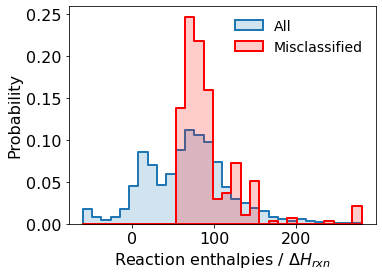

In [71]:
fig_reactions, ax_reactions = plt.subplots(figsize=(5.5,4))

sns.histplot(peroxide_reactions.reaction_enthalpies.dropna(), bins=30, element='step', linewidth=2, alpha=.2, ax=ax_reactions, stat='probability', binrange=(-60, 280), label='All')
sns.histplot(peroxide_reactions[mask_false_negative].reaction_enthalpies.dropna(), bins=30, element='step', linewidth=2, alpha=.2, ax=ax_reactions, stat='probability', color='red',  binrange=(-60, 280), label='Misclassified')
ax_reactions.legend(fontsize=14, fancybox=False, frameon=False)
ax_reactions.set(xlabel=r'Reaction enthalpies / $\Delta H_{rxn}$')

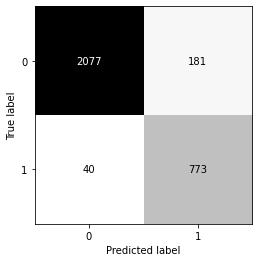

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(colorbar=False, cmap='Greys')

In [24]:
min(peroxide_reactions[mask_false_negative].reaction_enthalpies)

59.27432999999999

# Can I find the three reactions

In [30]:
R37 = 865
R38 = 866
R69_1 = 6183
R69_2 = 6184
R53_1 = 3666

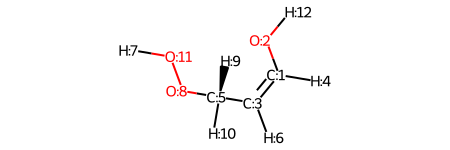

In [31]:
Chem.MolFromSmiles(peroxide_reactions.loc[R53_1].mapped_psmi, sanitize=False)